In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from salishsea_tools import (psu_tools, teos_tools)

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
import gsw

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation')
import general_functions

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_vars_pressure(dirname, fname, meshmaskname, time_ind):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U') 
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesT) as dsT:
        vosaline0 = dsT.variables['vosaline'][time_ind, :, y, x]
        votemper0 = dsT.variables['votemper'][time_ind, :, y, x]
        sossheig0 = dsT.variables['sossheig'][time_ind, y, x]

    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        tmask = dsM.variables['tmask'][0, :, y, x]
        tmask_ssh = dsM.variables['tmask'][0, 0, y, x]
        gdept = dsM.variables['gdept_1d'][0, :]
        e3t = dsM.variables['e3t_0'][0, :, 0, 0]
        nav_lat = dsM.variables['nav_lat'][y, x]

    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    votemper = np.ma.array(votemper0, mask=1 - tmask)
    sossheig = np.ma.array(sossheig0, mask=1 - tmask_ssh)
    
    return vosaline, votemper, sossheig, gdept, e3t, nav_lat

In [3]:
kind = 'ideal'
case = 'base' 
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

In [4]:
time_ind = 36
vosaline, votemper, sossheig, gdept, e3t, nav_lat = get_vars_pressure(dirname, fname, meshmaskname, time_ind)

In [5]:
vosaline.shape, votemper.shape, sossheig.shape, gdept.shape, e3t.shape, nav_lat.shape

((80, 242, 272), (80, 242, 272), (242, 272), (80,), (80,), (242, 272))

In [6]:
dep = 9 
this_votemper = votemper[dep, :, :]
this_vosaline = teos_tools.teos_psu(vosaline[dep, :, :]) # Convert TEOS-10 reference salinity in g/kg to practical salinity units (psu)
density = psu_tools.calculate_density(this_votemper, this_vosaline) # Calculates the density given temperature in deg C (t) and salinity in psu (s)
#the density as an array (rho) in kg/m^3

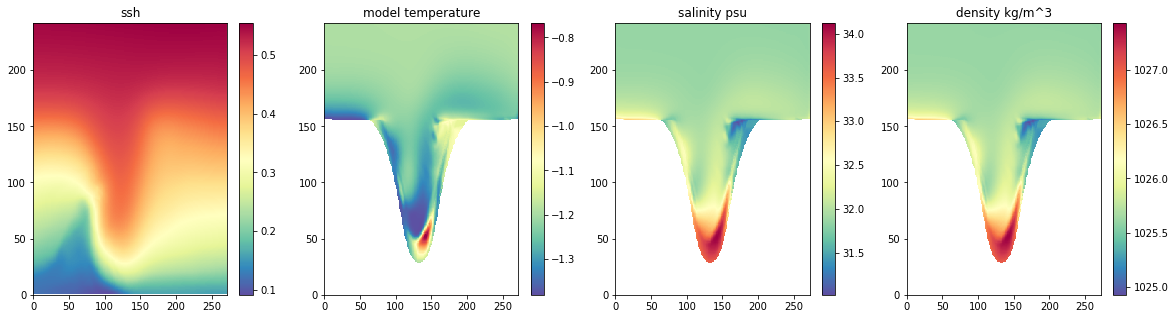

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
plots = [sossheig, this_votemper, this_vosaline, density]
ttls = ['ssh', 'model temperature', 'salinity psu', 'density kg/m^3']
for n, plot, ttl in zip(np.arange(4), plots, ttls):
    p = ax[n].pcolormesh(plot, cmap=cm.Spectral_r)
    fig.colorbar(p, ax=ax[n])
    ax[n].set_title(ttl)

Try again with gsw functions - figure out shapes

In [61]:
pressure_dep = gsw.p_from_z(-1*gdept[:], np.mean(nav_lat))

In [78]:
vosaline.shape[-3], vosaline.shape[-2], vosaline.shape[-1]

(80, 242, 272)

In [79]:
rho_dep = np.full([vosaline.shape[-3], vosaline.shape[-2], vosaline.shape[-1]], np.nan)
for k in range(vosaline.shape[-3],):
    print(k)
    gsw_vosaline = vosaline[k, :, :]
    gsw_votemper = votemper[k, :, :]
    rho_dep[k, :, :] = gsw.rho(gsw_vosaline, gsw_votemper, pressure_dep[k])
rho_dep.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


(80, 242, 272)

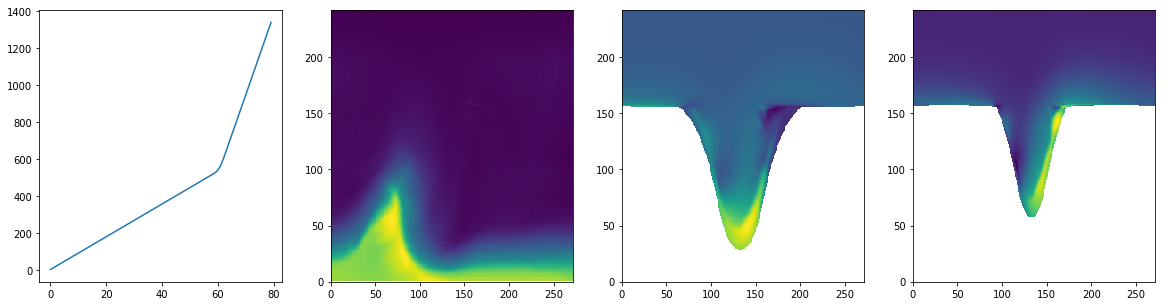

In [82]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].plot(pressure_dep)
ax[1].pcolormesh(rho_dep[0, :, :])
ax[2].pcolormesh(rho_dep[9, :, :])
ax[3].pcolormesh(rho_dep[16, :, :])